<a href="https://colab.research.google.com/github/musab-r/Computational_Intelligence_Project/blob/main/Phase%202%20NN%2C%20FS%2C%20GA/Fuzzy_Systems_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computational Intelligence Project: Sentiment Analysis on IMDB dataset Using Fuzzy System

Sentiment analysis is one of the key areas of research in NLP and Sequence modelling. I will be using fuzzy systems to predict two classes - positive or negative sentiment. 

In [ ]:
import re
import os
import time
import pandas as pd
import numpy as np
!pip install -U scikit-fuzzy
import skfuzzy as fuzz
import nltk
nltk.download('vader_lexicon')
from keras.datasets import imdb
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer


Requirement already up-to-date: scikit-fuzzy in /usr/local/lib/python3.7/dist-packages (0.4.2)
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


### Step 1| Loading IMDB Dataset 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

dataset = "IMDB Dataset.csv"
drive_path = '/content/drive/My Drive/Computational Intelligence/'
path = os.path.join(drive_path, dataset)
df = pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
start = time.time()

X_train = df
doc = X_train.review
print(len(doc))
senti_doc = X_train.sentiment

50000


In [ ]:
df.head

<bound method NDFrame.head of                                                   review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]>

In [ ]:
# Generate variables
x_p = np.arange(0, 1, 0.1)
x_n = np.arange(0, 1, 0.1)
x_op = np.arange(0, 10, 1)

## Membership Functions

In [ ]:
# Generate fuzzy membership functions
p_lo = fuzz.trimf(x_p, [0, 0, 0.5])
p_md = fuzz.trimf(x_p, [0, 0.5, 1])
p_hi = fuzz.trimf(x_p, [0.5, 1, 1])
n_lo = fuzz.trimf(x_n, [0, 0, 0.5])
n_md = fuzz.trimf(x_n, [0, 0.5, 1])
n_hi = fuzz.trimf(x_n, [0.5, 1, 1])
op_Neg = fuzz.trimf(x_op, [0, 0, 5])
op_Neu = fuzz.trimf(x_op, [0, 5, 10])
op_Pos = fuzz.trimf(x_op, [5, 10, 10])

### Visualization of Memvership Functions

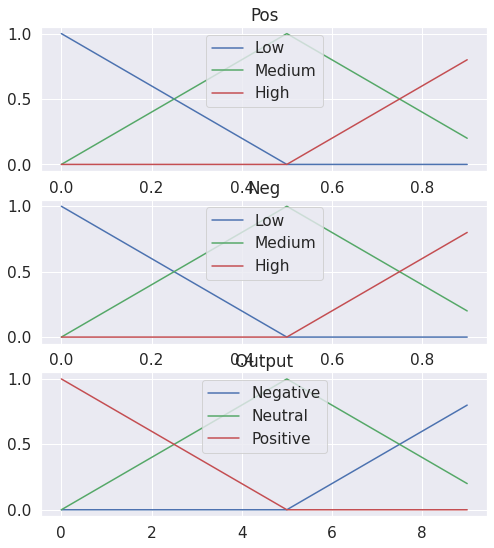

In [ ]:
# Visualize membership functions
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 9))
#
ax0.plot(x_p, p_lo, 'b', linewidth=1.5, label='Low')
ax0.plot(x_p, p_md, 'g', linewidth=1.5, label='Medium')
ax0.plot(x_p, p_hi, 'r', linewidth=1.5, label='High')
ax0.set_title('Pos')
ax0.legend()

ax1.plot(x_n, n_lo, 'b', linewidth=1.5, label='Low')
ax1.plot(x_n, n_md, 'g', linewidth=1.5, label='Medium')
ax1.plot(x_n, n_hi, 'r', linewidth=1.5, label='High')
ax1.set_title('Neg')
ax1.legend()

ax2.plot(x_op, op_Pos, 'b', linewidth=1.5, label='Negative')
ax2.plot(x_op, op_Neu, 'g', linewidth=1.5, label='Neutral')
ax2.plot(x_op, op_Neg, 'r', linewidth=1.5, label='Positive')
ax2.set_title('Output')
ax2.legend()

## Preprocessing

In [ ]:
contractions = {
"ain't": "am not / are not", "aren't": "are not / am not","can't": "cannot","can't've": "cannot have","'cause": "because",
"could've": "could have","couldn't": "could not","couldn't've": "could not have","didn't": "did not","doesn't": "does not",
"don't": "do not","hadn't": "had not","hadn't've": "had not have","hasn't": "has not","haven't": "have not",
"he'd": "he had / he would","he'd've": "he would have","he'll": "he shall / he will",
"he'll've": "he shall have / he will have","he's": "he has / he is","how'd": "how did","how'd'y": "how do you",
"how'll": "how will","how's": "how has / how is","i'd": "I had / I would","i'd've": "I would have","i'll": "I shall / I will",
"i'll've": "I shall have / I will have","i'm": "I am","i've": "I have","isn't": "is not","it'd": "it had / it would",
"it'd've": "it would have","it'll": "it shall / it will","it'll've": "it shall have / it will have","it's": "it has / it is",
"let's": "let us","ma'am": "madam","mayn't": "may not",
"might've": "might have","mightn't": "might not","mightn't've": "might not have","must've": "must have","mustn't": "must not",
"mustn't've": "must not have","needn't": "need not","needn't've": "need not have","o'clock": "of the clock",
"oughtn't": "ought not","oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
"shan't've": "shall not have","she'd": "she had / she would","she'd've": "she would have","she'll": "she shall / she will",
"she'll've": "she shall have / she will have","she's": "she has / she is","should've": "should have","shouldn't": "should not",
"shouldn't've": "should not have","so've": "so have","so's": "so as / so is","that'd": "that would / that had",
"that'd've": "that would have","that's": "that has / that is","there'd": "there had / there would",
"there'd've": "there would have","there's": "there has / there is","they'd": "they had / they would",
"they'd've": "they would have","they'll": "they shall / they will","they'll've": "they shall have / they will have",
"they're": "they are","they've": "they have","to've": "to have","wasn't": "was not","we'd": "we had / we would",
"we'd've": "we would have","we'll": "we will","we'll've": "we will have","we're": "we are","we've": "we have",
"weren't": "were not","what'll": "what shall / what will","what'll've": "what shall have / what will have",
"what're": "what are","what's": "what has / what is","what've": "what have","when's": "when has / when is",
"when've": "when have","where'd": "where did","where's": "where has / where is","where've": "where have","who'll": "who shall / who will",
"who'll've": "who shall have / who will have","who's": "who has / who is","who've": "who have","why's": "why has / why is",
"why've": "why have","will've": "will have","won't": "will not","won't've": "will not have","would've": "would have",
"wouldn't": "would not","wouldn't've": "would not have","y'all": "you all","y'all'd": "you all would",
"y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you had / you would",
"you'd've": "you would have","you'll": "you shall / you will","you'll've": "you shall have / you will have",
"you're": "you are","you've": "you have"
}

In [ ]:
def identify_contractions(dataframe):
    for i in range(0, len(dataframe)):
        for word in dataframe[i].split():
            if word.lower() in contractions:
                dataframe[i] = dataframe[i].replace(word, contractions[word.lower()])
    return dataframe

In [ ]:
X_train['review'] = identify_contractions(X_train['review'])

In [ ]:
tweets=[]
senti=[]
sentiment=[]
sentiment_doc=[]

for j in range(len(doc)):
    str1=X_train.review[j]
    str2=str1.lower()
    tweets.append(str2)   # converted into lower case
    senti.append(X_train.sentiment[j])

def decontracted(phrase):   # text pre-processing 
        # specific
        phrase = re.sub(r"won't", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)
        phrase = re.sub(r"@", "" , phrase)         # removal of @
        phrase =  re.sub(r"http\S+", "", phrase)   # removal of URLs
        phrase = re.sub(r"#", "", phrase)          # hashtag processing
    
        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        return phrase
    
for k in range(len(doc)):
    tweets[k]=decontracted(tweets[k])
         
sid = SentimentIntensityAnalyzer()


## Output of Fuzzy System

In [ ]:
for j in range(len(doc)):
  sentiment_doc.append(senti[j])
  ss = sid.polarity_scores(tweets[j])
  posscore=ss['pos']
  negscore=ss['neg']
  neuscore=ss['neu']
  compoundscore=ss['compound']

  # print(str(j+1)+" {:-<65} {}".format(tweets[j], str(ss))) 
  print("Review: ", j) 

  print("\nPositive Score for each  review :")    
  if (posscore==1):
    posscore=0.9 
  else:
    posscore=round(posscore,1)
  print(posscore)

  print("\nNegative Score for each  review :")
  if (negscore==1):
    negscore=0.9
  else:
    negscore=round(negscore,1)
  print(negscore)

  # We need the activation of our fuzzy membership functions at these values.
  p_level_lo = fuzz.interp_membership(x_p, p_lo, posscore)
  p_level_md = fuzz.interp_membership(x_p, p_md, posscore)
  p_level_hi = fuzz.interp_membership(x_p, p_hi, posscore)

  n_level_lo = fuzz.interp_membership(x_n, n_lo, negscore)
  n_level_md = fuzz.interp_membership(x_n, n_md, negscore)
  n_level_hi = fuzz.interp_membership(x_n, n_hi, negscore)

  # Now we take our rules and apply them. Rule 1 concerns bad OR nice.
  # The OR operator means we take the maximum of these two.
  active_rule1 = np.fmin(p_level_lo, n_level_lo)
  active_rule2 = np.fmin(p_level_md, n_level_lo)
  active_rule3 = np.fmin(p_level_hi, n_level_lo)
  active_rule4 = np.fmin(p_level_lo, n_level_md)
  active_rule5 = np.fmin(p_level_md, n_level_md)
  active_rule6 = np.fmin(p_level_hi, n_level_md)
  active_rule7 = np.fmin(p_level_lo, n_level_hi)
  active_rule8 = np.fmin(p_level_md, n_level_hi)
  active_rule9 = np.fmin(p_level_hi, n_level_hi)
    
  # Now we apply this by clipping the top off the corresponding output
  # membership function with `np.fmin`

  n1=np.fmax(active_rule4,active_rule7)
  n2=np.fmax(n1,active_rule8)     
  op_activation_lo = np.fmin(n2,op_Neg)

  neu1=np.fmax(active_rule1,active_rule5)
  neu2=np.fmax(neu1,active_rule9)     
  op_activation_md = np.fmin(neu2,op_Neu)

  p1=np.fmax(active_rule2,active_rule3)
  p2=np.fmax(p1,active_rule6)   
  op_activation_hi = np.fmin(p2,op_Pos)

  op0 = np.zeros_like(x_op)

  # Aggregate all three output membership functions together
  aggregated = np.fmax(op_activation_lo,
                       np.fmax(op_activation_md, op_activation_hi))
    
  # Calculate defuzzified result
  op = fuzz.defuzz(x_op, aggregated, 'centroid')
  output=round(op,2)

  op_activation = fuzz.interp_membership(x_op, aggregated, op)  # for plot
         
  print("\nFiring Strength of Negative (wneg): "+str(round(n2,4)))
  print("Firing Strength of Neutral (wneu): "+str(round(neu2,4)))
  print("Firing Strength of Positive (wpos): "+str(round(p2,4)))

  print("\nResultant consequents MFs:" )
  print("op_activation_low: "+str(op_activation_lo))
  print("op_activation_med: "+str(op_activation_md))
  print("op_activation_high: "+str(op_activation_hi))

  print("\nAggregated Output: "+str(aggregated))
  print("\nDefuzzified Output: "+str(output))

# Scale : Neg Pos   
  if 0<(output)<4.99:    # R
      print("\nOutput after Defuzzification: Negative")
      sentiment.append("Negative")
      
  elif 5<(output)<10:
      print("\nOutput after Defuzzification: Positive")
      sentiment.append("Positive")
      
  print("Doc sentiment: " +str(senti[j])+"\n")    
  

Streaming output truncated to the last 5000 lines.

Aggregated Output: [0.2 0.2 0.4 0.6 0.8 0.8 0.8 0.6 0.4 0.2]

Defuzzified Output: 4.81

Output after Defuzzification: Negative
Doc sentiment: positive

Review:  49792

Positive Score for each  review :
0.1

Negative Score for each  review :
0.0

Firing Strength of Negative (wneg): 0.0
Firing Strength of Neutral (wneu): 0.8
Firing Strength of Positive (wpos): 0.2

Resultant consequents MFs:
op_activation_low: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
op_activation_med: [0.  0.2 0.4 0.6 0.8 0.8 0.8 0.6 0.4 0.2]
op_activation_high: [0.  0.  0.  0.  0.  0.  0.2 0.2 0.2 0.2]

Aggregated Output: [0.  0.2 0.4 0.6 0.8 0.8 0.8 0.6 0.4 0.2]

Defuzzified Output: 4.91

Output after Defuzzification: Negative
Doc sentiment: positive

Review:  49793

Positive Score for each  review :
0.2

Negative Score for each  review :
0.1

Firing Strength of Negative (wneg): 0.2
Firing Strength of Neutral (wneu): 0.6
Firing Strength of Positive (wpos): 0.4

Resultant cons

## Evaluation

In [ ]:
for i in range(len(doc)):
  if sentiment_doc[i] == 'positive':
    sentiment_doc[i] = 'Positive'
  else:
    sentiment_doc[i] = 'Negative'

In [ ]:
count=0
for k in range(len(doc)):
    if(sentiment_doc[k]==sentiment[k]):
        count=count+1       
print("Accuracy is: "+ str(round(count/len(doc)*100,2)))


Accuracy is: 54.91


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score
y_true = sentiment_doc
y_pred = sentiment

p1=precision_score(y_true, y_pred, average='macro')  

print("Precision score (MACRO): " + str(round((p1*100),2)))

r1=recall_score(y_true, y_pred, average='macro')  

print("Recall score (MACRO): " + str(round((r1*100),2)))

f1=f1_score(y_true, y_pred, average='macro')  
f2=f1_score(y_true, y_pred, average='micro')  

print("F1 score (MACRO): " + str(round((f1*100),2)))
print("F1 score (MICRO): "+ str(round((f2*100),2)))

end = time.time()
print("Execution Time: "+str(round((end - start),3))+" secs")

Precision score (MACRO): 71.97
Recall score (MACRO): 54.91
F1 score (MACRO): 44.04
F1 score (MICRO): 54.91
Execution Time: 429.119 secs


In [ ]:
from sklearn.metrics import classification_report
print("Classification Report\n",classification_report(y_true, y_pred, labels=['Positive','Negative'], target_names = ['Neg', 'Pos']))

Classification Report
               precision    recall  f1-score   support

         Neg       0.91      0.11      0.19     25000
         Pos       0.53      0.99      0.69     25000

    accuracy                           0.55     50000
   macro avg       0.72      0.55      0.44     50000
weighted avg       0.72      0.55      0.44     50000



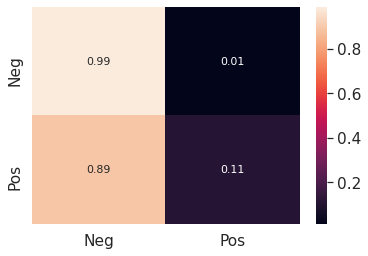

In [ ]:
from sklearn.metrics import confusion_matrix   
import seaborn as sn

cm=confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, ['Neg', 'Pos'],['Neg', 'Pos'] )# matrix,names row,names col,
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 11}, fmt=".2f") # font size
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.54908